# Bayesian estimation of the bivariate beta parameter

In [198]:
import logging
logger = logging.getLogger('cmdstanpy')
logger.setLevel(logging.CRITICAL)

import os
import tqdm
import numpy as np
from scipy import stats
import pandas as pd

from cmdstanpy import cmdstan_path, CmdStanModel, set_cmdstan_path, install_cmdstan

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import arviz as az
#plt.style.use('science')

import sys
sys.path.append('../scripts/python')
    
from parameter_estimation import BivariateBeta

## Stan Model

For using the following notebook, it is necessary to set the `cmdstan` path correctly. 

In [2]:
set_cmdstan_path('/home/lucasmoschen/anaconda3/envs/project-beta/bin/cmdstan')

Then, we can proceed the compilation.

In [3]:
stanfile = os.path.join('..', 'scripts', 'stan', 'bivariate-beta-model-v1.stan')
model1 = CmdStanModel(stan_file=stanfile, cpp_options={'STAN_THREADS':True})

stanfile = os.path.join('..', 'scripts', 'stan', 'bivariate-beta-model-v2.stan')
model2 = CmdStanModel(stan_file=stanfile, cpp_options={'STAN_THREADS': True})

stanfile = os.path.join('..', 'scripts', 'stan', 'bivariate-beta-model-v3.stan')
model3 = CmdStanModel(stan_file=stanfile, cpp_options={'STAN_THREADS': True})

## Default hyperparameters

Generating the data

In [17]:
def generate_data(true_alpha, n, seed):
    ro = np.random.RandomState(seed=seed)
    U = ro.dirichlet(true_alpha, size=n)
    X = U[:,0] + U[:,1]
    Y = U[:,0] + U[:,2]
    XY = np.column_stack([X,Y])
    return XY, U

## Simulated-based calibration

https://arxiv.org/pdf/1804.06788.pdf

https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html

Consider the prior $\alpha \sim \operatorname{Gamma}(a=2, b=2)$

In [95]:
a, b = 2,2

# Gamma hyperparameters
a = a*np.ones(4)
b = b*np.ones(4)

# bojum prior
m = -0.9
r = b

# uniform-exponential prior
p = 0.5*np.ones(4)
lambd = np.ones(4)
c = 100*np.ones(4)

n = 50

data = {'n': n, 'prior_alpha': 1, 'a': a, 'b': b, 'm': m, 'r': r, 'p': p, 'lambda': lambd, 'c': c}

R = 63
N = 1000

Let's see the distribution of $\rho = \#\{\alpha_1 < \hat{\alpha}_1\}$.

In [96]:
rho_values = []
rng = np.random.RandomState(831290)

for _ in tqdm.trange(N):
    true_alpha = rng.gamma(shape=a, scale=1/b, size=4)
    seed=rng.randint(831290)
    XY, U = generate_data(true_alpha, n, seed=seed)
    if U[U<=0].shape[0] + XY[XY>=1].shape[0] > 0:
        print(len(rho_values))
        continue
    data['xy'] = XY
    model_fit = model3.sample(data=data, iter_warmup=1000, iter_sampling=1000, chains=1, adapt_delta=0.9,
                              show_progress=False, show_console=False)
    alpha_estimates = (model_fit.stan_variables()['alpha'])[rng.choice(range(1000), size=R, replace=False)]
    rho = np.sum(alpha_estimates > true_alpha, axis=0)
    rho_values.append({'rho': rho, 
                       'diagnose': model_fit.diagnose(),
                       'true_alpha': true_alpha, 
                       'seed': seed,
                       'XY': XY,
                       'U': U})

 87%|█████████████████████████████████████████████████████████████████████▋          | 871/1000 [12:18<02:09,  1.00s/it]

871


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [14:02<00:00,  1.19it/s]


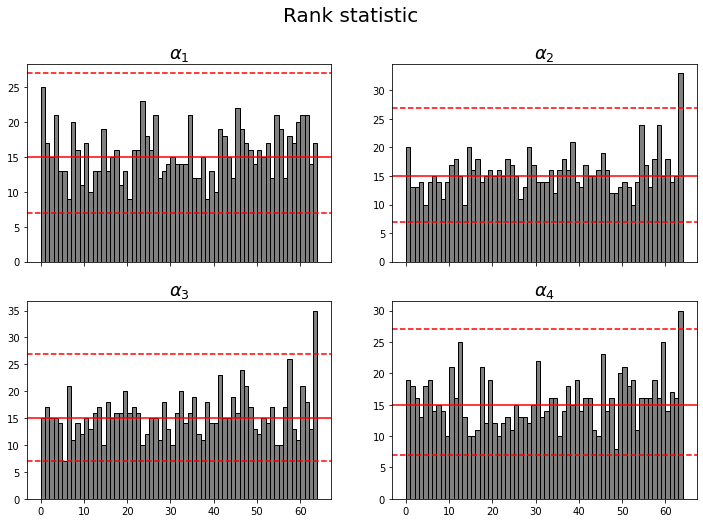

In [159]:
fig, ax = plt.subplots(2,2,figsize=(12,8), sharex=True)

for i in range(4):
    ax[i//2,i%2].hist(np.array([i['rho'] for i in rho_values])[:,i], color='grey', edgecolor='black', bins=range(R+2))
    ax[i//2,i%2].set_title(r'$\alpha_{}$'.format(i+1), fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].axhline(stats.binom(n=len(rho_values), p=1/(R+1)).ppf(0.005), color='red', linestyle='--')
        ax[i,j].axhline(stats.binom(n=len(rho_values), p=1/(R+1)).ppf(0.5), color='red', linestyle='-')
        ax[i,j].axhline(stats.binom(n=len(rho_values), p=1/(R+1)).ppf(0.995), color='red', linestyle='--')
    
fig.suptitle('Rank statistic', fontsize=20)
plt.show()

In [152]:
for i in rho_values:
    txt = "\n\nChecking sampler transitions for divergences.\n"
    diagnose = i['diagnose']
    pos = diagnose.find(txt)
    divergences = diagnose[pos+len(txt):].split()[0]
    if divergences == 'No':
        divergences = 0
    else:
        divergences = int(divergences)
    i['divergences'] = divergences
    
values = np.zeros((len(rho_values), 2))
for i in range(len(rho_values)):
    values[i,0] = min(rho_values[i]['true_alpha'])
    values[i,1] = rho_values[i]['divergences']

Text(0, 0.5, 'Number of divergences')

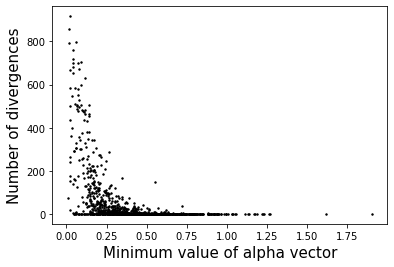

In [158]:
plt.scatter(values[:,0], values[:,1], s=2, color='black')
plt.xlabel('Minimum value of alpha vector', fontsize=15)
plt.ylabel('Number of divergences', fontsize=15)

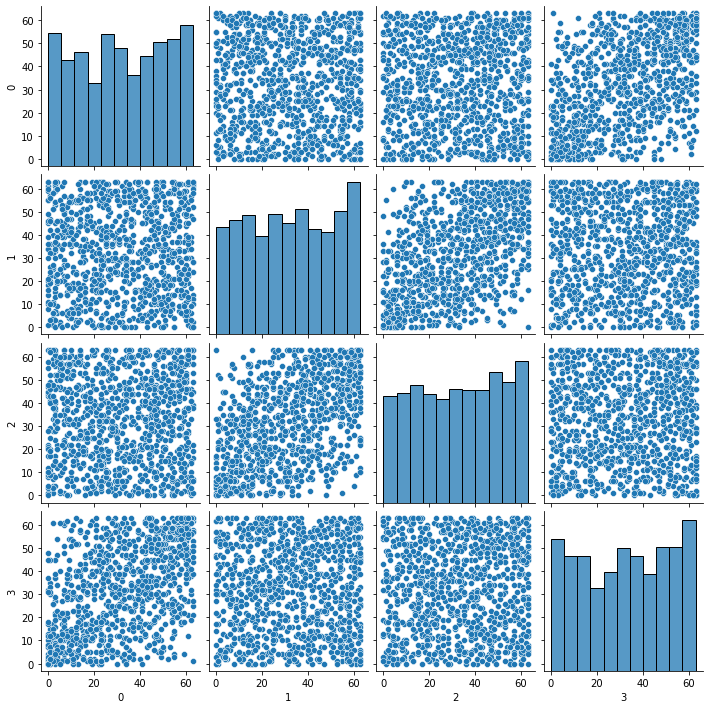

In [199]:
sns.pairplot(data=pd.DataFrame(np.array([i['rho'] for i in rho_values])))